In [1]:
import json
import os
import time
import warnings

import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pysam
import pyfaidx
import pybedtools
import csv
import tensorflow as tf

from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

from borzoi_helpers import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2025-02-18 07:08:40.684158: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-18 07:08:40.684220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-18 07:08:40.685402: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 07:08:40.693225: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-18 07:08:42.198256: W tensorflow/compiler/tf2

In [ ]:
#Model configuration

params_file = 'params.json'
targets_file = 'targets_rna3_only.txt' #Subset of targets_human.txt

seq_len = 524288
n_reps = 4       #To use only one model replicate, set to 'n_reps = 1'. To use all four replicates, set 'n_reps = 4'.
rc = True         #Average across reverse-complement prediction

#Read model parameters

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Remove cropping
##params_model['trunk'][-1]['cropping'] = 0

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = targets_df.strand_pair
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

#Initialize model ensemble

models = []
for rep_ix in range(n_reps) :
    
    model_file = "saved_models/f3c" + str(rep_ix) + "/train/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, [0])
    
    models.append(seqnn_model)


In [5]:
#Load genome fasta and gene annotations

#Initialize fasta sequence extractor
fasta_open = pysam.Fastafile('hg38/assembly/ucsc/hg38.fa')

#Load gene/exon annotation
gtf_file = 'hg38/genes/gencode41/gencode41_basic_nort.gtf'

transcriptome = bgene.Transcriptome(gtf_file)

#Get gene span bedtool
bedt_span = transcriptome.bedtool_span()

#Load APA atlas
apa_df = pd.read_csv('hg38/genes/polyadb/polyadb_human_v3.csv.gz', sep='\t', compression='gzip')
apa_df = apa_df[['pas_id', 'gene', 'chrom', 'position_hg38', 'strand', 'site_num', 'num_sites', 'site_type', 'pas_type', 'total_count']]

apa_df.loc[apa_df['pas_type'] == 'NoPAS', 'pas_type'] = 'No_CSE'

#Only consider 3' UTR sites
apa_df_utr = apa_df.query("site_type == '3\\' most exon'").copy().reset_index(drop=True)

#Or intronic sites
apa_df_intron = apa_df.query("site_type == 'Intron' and pas_type != 'No_CSE'").copy().reset_index(drop=True)

print("len(apa_df_utr) = " + str(len(apa_df_utr)))
print("len(apa_df_intron) = " + str(len(apa_df_intron)))

#Load TSS atlas
tss_df = pd.read_csv('hg38/genes/gencode41/gencode41_basic_tss2.bed', sep='\t', names=['chrom', 'position_hg38', 'end', 'tss_id', 'feat1', 'strand'])
tss_df['gene'] = tss_df['tss_id'].apply(lambda x: x.split("/")[1] if "/" in x else x)

print("len(tss_df) = " + str(len(tss_df)))


len(apa_df_utr) = 114605
len(apa_df_intron) = 83473
len(tss_df) = 116649


In [6]:
#Get reference/alternate sequence for variant, and annotations for target gene

search_gene = 'ENSG00000131686'

center_pos = 8971277

chrom = 'chr1'
poses = [8971277]
alts = ['A']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

load_isoforms = True

#Get exon bin range
gene_keys = [gene_key for gene_key in transcriptome.genes.keys() if search_gene in gene_key]

gene = transcriptome.genes[gene_keys[0]]
gene_strand = gene.strand

if chrom is None or start is None or end is None :
    chrom = gene.chrom
    g_start, g_end = gene.span()
    mid = (g_start + g_end) // 2
    start = mid - seq_len // 2
    end = mid + seq_len // 2

#Determine output sequence start
seq_out_start = start + seqnn_model.model_strides[0]*seqnn_model.target_crops[0]
seq_out_len = seqnn_model.model_strides[0]*seqnn_model.target_lengths[0]

#Determine output positions of gene exons
gene_slice = gene.output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False, old_version=True)

#Get sequence bedtool
seq_bedt = pybedtools.BedTool('%s %d %d' % (chrom, start, end), from_string=True)

#Get all genes (exons and strands) overlapping input window
gene_ids = sorted(list(set([overlap[3] for overlap in bedt_span.intersect(seq_bedt, wo=True) if search_gene not in overlap[3]])))
gene_slices = []
gene_strands = []
for gene_id in gene_ids :
    gene_slices.append(transcriptome.genes[gene_id].output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False, old_version=True))
    gene_strands.append(transcriptome.genes[gene_id].strand)

#Get 3' UTR pA sites for gene
apa_df_gene_utr = apa_df_utr.query("gene == '" + gene.name + "'").copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]
apa_df_gene_intron = apa_df_intron.query("gene == '" + gene.name + "'").copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]

#Get TSS sites for gene
tss_df_gene = tss_df.loc[tss_df['gene'].str.contains(search_gene)].copy().reset_index(drop=True)[['chrom', 'gene', 'strand', 'position_hg38']]

def _switch_transcript_id(id_str) :
    return id_str.replace("gene_id", "gene_id_orig").replace("transcript_id", "gene_id")

#Get gene isoforms
isoform_slices = None
if load_isoforms :
    gtf_df = pd.read_csv(gtf_file, sep='\t', skiprows=5, names=['chrom', 'havana_str', 'feature', 'start', 'end', 'feat1', 'strand', 'feat2', 'id_str'])
    gtf_df = gtf_df.loc[gtf_df['id_str'].str.contains(search_gene)].copy().reset_index(drop=True)
    gtf_df = gtf_df.loc[gtf_df['id_str'].str.contains("transcript_id")].copy().reset_index(drop=True)
    gtf_df = gtf_df.loc[gtf_df['feature'] == 'exon'].copy().reset_index(drop=True)
    
    transcript_ids = gtf_df['id_str'].apply(lambda x: x.split("transcript_id \"")[1].split("\";")[0]).unique().tolist()
    gtf_df['id_str'] = gtf_df['id_str'].apply(_switch_transcript_id)
    
    gtf_df.to_csv('borzoi_gene_isoforms.gtf', sep='\t', index=False, header=False, quoting=csv.QUOTE_NONE)
    
    transcriptome_iso = bgene.Transcriptome('borzoi_gene_isoforms.gtf')
    
    isoform_slices = []
    for transcript_id in transcript_ids :
        isoform_slices.append(transcriptome_iso.genes[transcript_id].output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False, old_version=True))


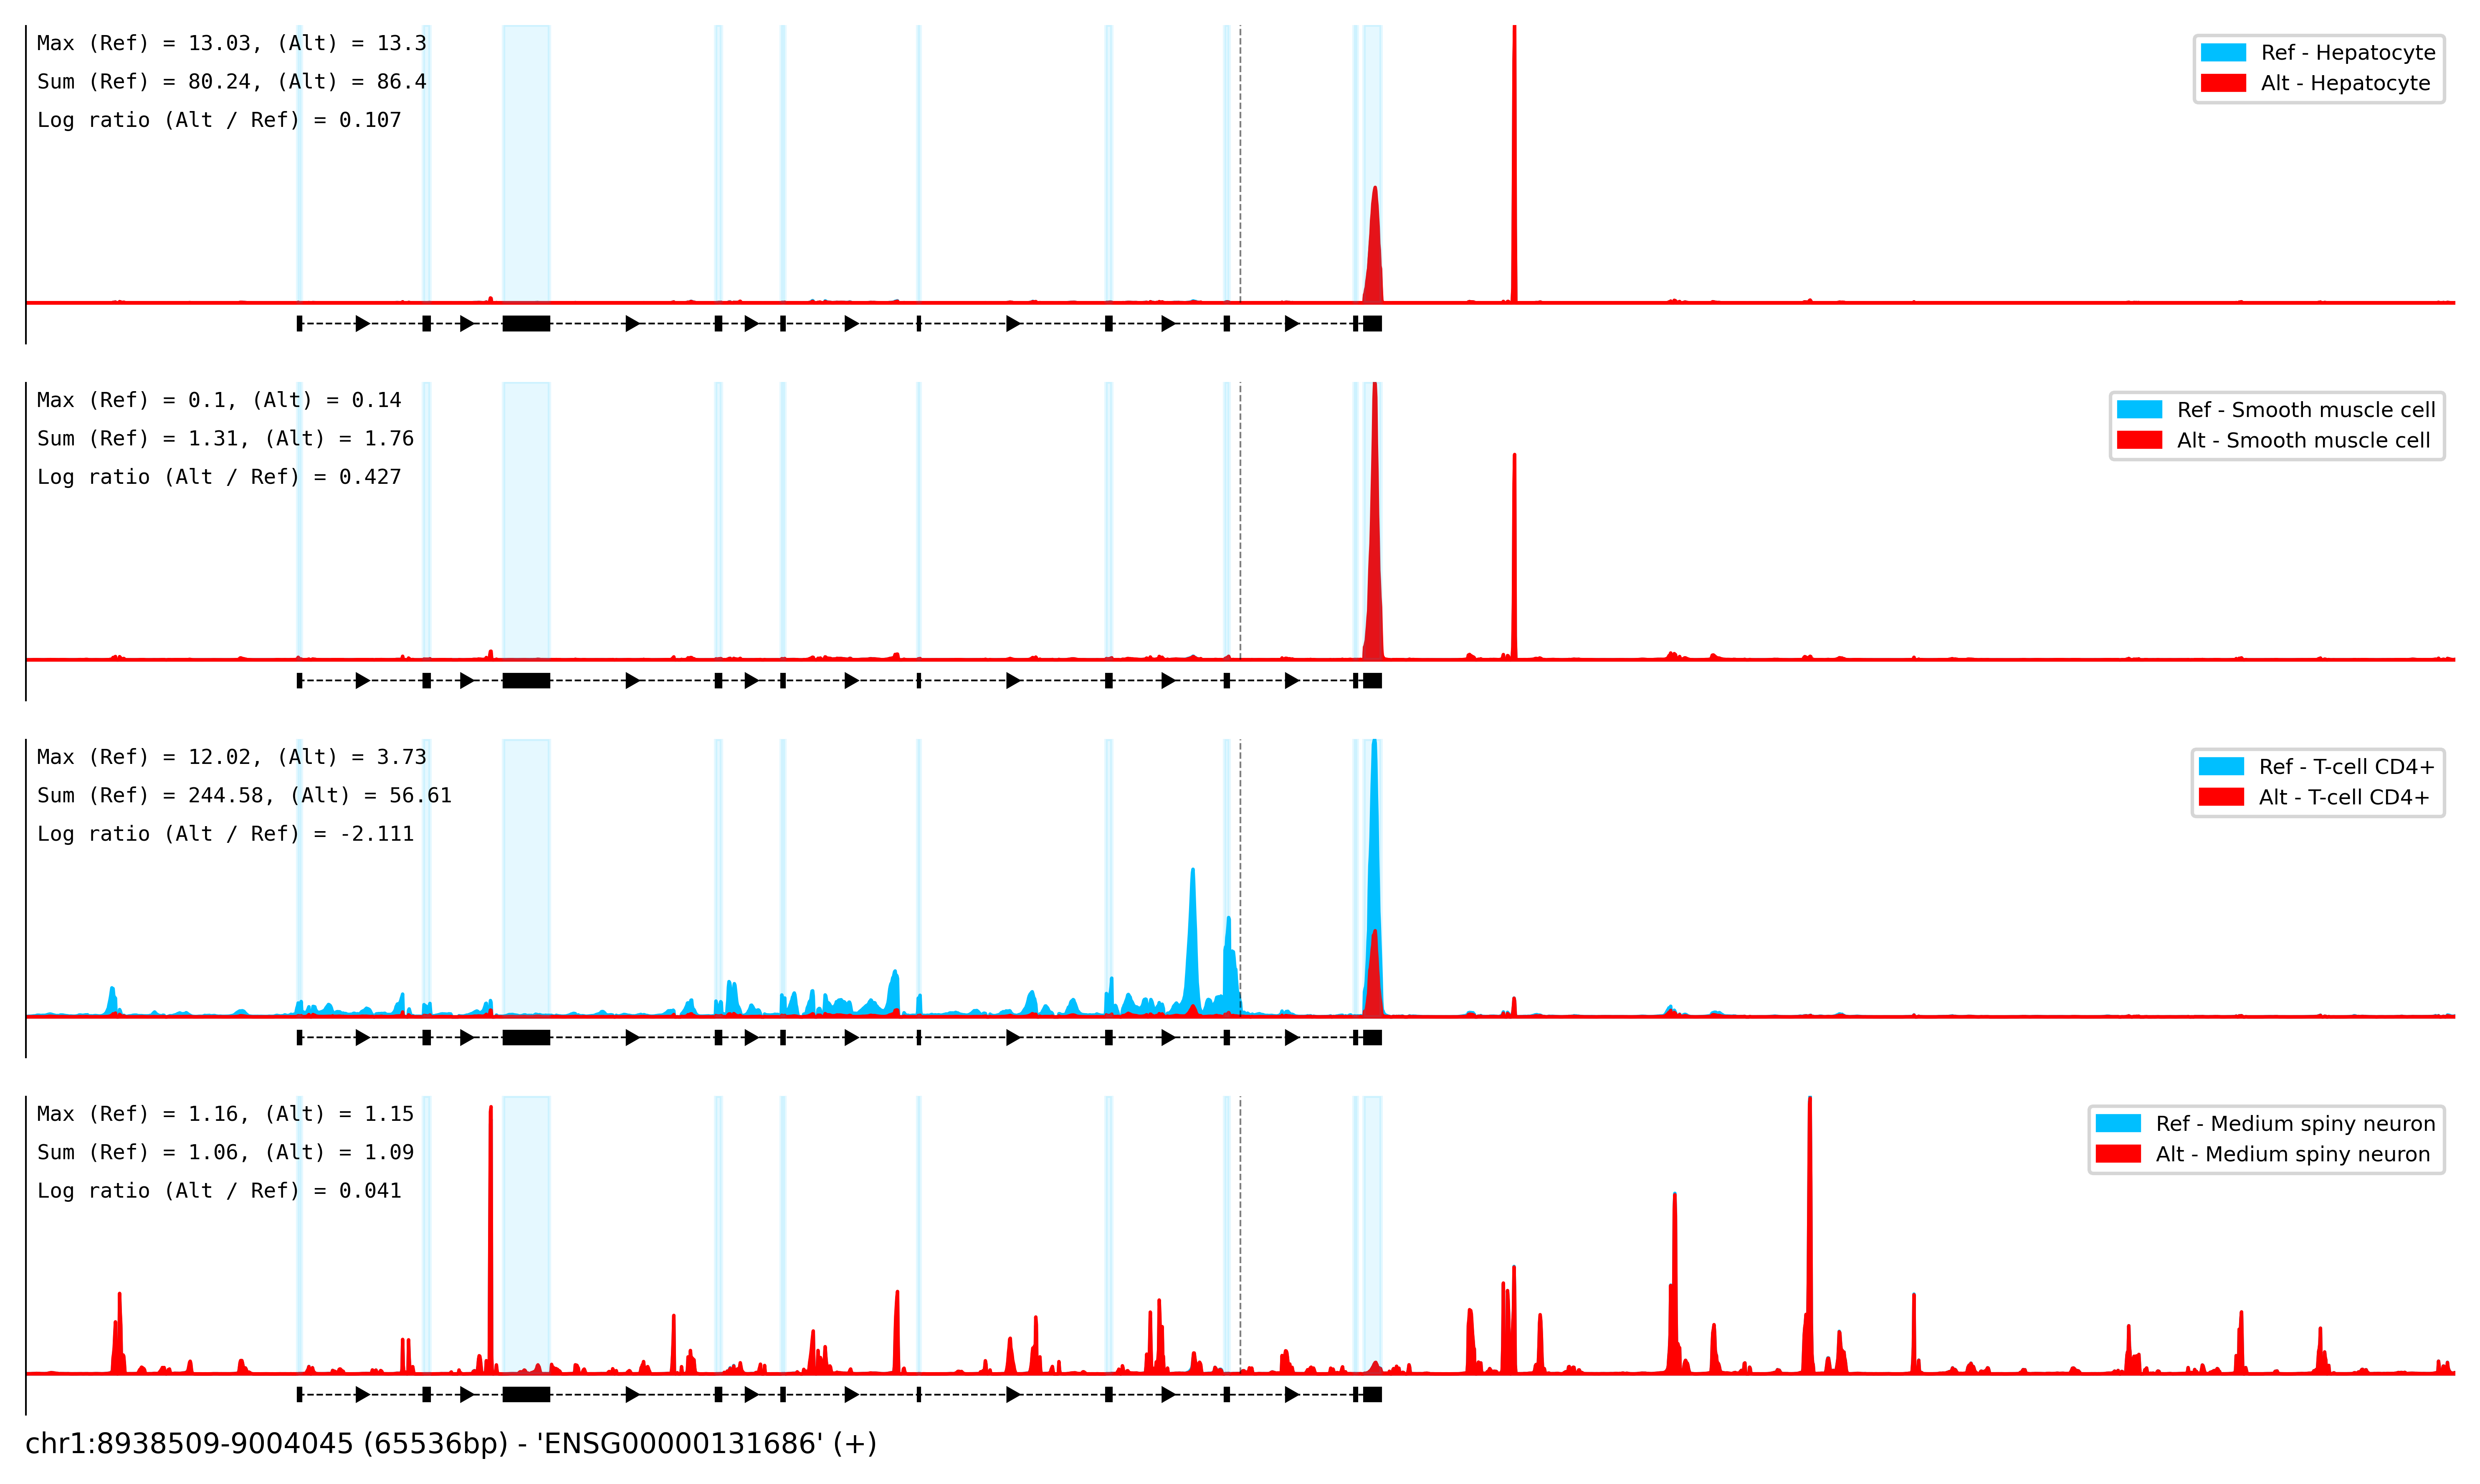

CPU times: user 20.3 s, sys: 2.19 s, total: 22.5 s
Wall time: 34.5 s


In [8]:
%%time
#Predict for chr1_8971277_G_A
# (~6 minutes on CPU w 1 replicate; ~2 minutes on GPU)

save_figs = True
save_suffix = '_chr1_8971277_G_A'

sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

highlight_pos_rel = poses[0] - start

#Induce mutation(s)
sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

for pos, alt in zip(poses, alts) :
    alt_ix = -1
    if alt == 'A' :
        alt_ix = 0
    elif alt == 'C' :
        alt_ix = 1
    elif alt == 'G' :
        alt_ix = 2
    elif alt == 'T' :
        alt_ix = 3

    sequence_one_hot_mut[pos-start-1] = 0.
    sequence_one_hot_mut[pos-start-1, alt_ix] = 1.

#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)
y_mut = predict_tracks(models, sequence_one_hot_mut)

g_start, g_end = gene.span()
gene_width = (g_end - g_start)

#Visualize coverage tracks
plot_start = 524288//2 - 196608//6
plot_end = 524288//2 + 196608//6
bin_size = 16
pad = 10240

#Tracks
track_indices = [
    np.nonzero((targets_df['identifier'].str.contains('tabula.*\\' + gene_strand) & targets_df['description'].str.contains('RNA3:Liver, hepatocyte')).values)[0].tolist(),
    np.nonzero((targets_df['identifier'].str.contains('tabula.*\\' + gene_strand) & targets_df['description'].str.contains('RNA3:Muscle, smooth muscle cell')).values)[0].tolist(),
    np.nonzero((targets_df['identifier'].str.contains('tabula.*\\' + gene_strand) & targets_df['description'].str.contains('RNA3:Blood, cd4-positive, alpha-beta t cell')).values)[0].tolist(),
    np.nonzero((targets_df['identifier'].str.contains('linnar.*\\' + gene_strand) & targets_df['description'].str.contains('RNA3:.*Medium spiny neuron')).values)[0].tolist(),
]

track_names = [
    'Hepatocyte',
    'Smooth muscle cell',
    'T-cell CD4+',
    'Medium spiny neuron',
]

track_colors = [
    ['deepskyblue', 'red'],
    ['deepskyblue', 'red'],
    ['deepskyblue', 'red'],
    ['deepskyblue', 'red'],
]

track_labels = [
    ['Hepatocyte'],
    ['Smooth muscle cell'],
    ['T-cell CD4+'],
    ['Medium spiny neuron'],
]

track_labels = [
    ['Ref', 'Alt'],
    ['Ref', 'Alt'],
    ['Ref', 'Alt'],
    ['Ref', 'Alt'],
]

track_scale = 1.
track_transform = 3./4.
soft_clip = None

untransform_old = False

#Plot coverage
plot_coverage_tracks(
    y_wt,
    track_indices,
    track_names,
    track_colors,
    track_labels,
    track_scale,
    track_transform,
    soft_clip,
    start,
    y_2_in=y_mut,
    plot_pair=True,
    pair_order=[0, 1],
    pair_alpha=1.,
    log_scale=False,
    same_scale=False,#True,
    highlight_pos_rel=highlight_pos_rel,
    plot_start_rel=plot_start,
    plot_end_rel=plot_end,
    bin_size=bin_size,
    pad=pad,
    save_figs=save_figs,
    save_suffix=save_suffix,
    gene_slice=gene_slice,
    gene_slices=gene_slices,
    isoform_slices=isoform_slices,
    gene_strand=gene_strand,
    chrom=chrom,
    search_gene=search_gene,
    gene_strands=gene_strands,
    apa_df_gene_utr=apa_df_gene_utr,
    apa_df_gene_intron=apa_df_gene_intron,
    tss_df_gene=tss_df_gene,
    annotate_utr_apa=False,
    annotate_intron_apa=False,
    annotate_tss=False,
    plot_strands=True,
    plot_other_genes=False,
    plot_other_gene_strands=False,
    plot_isoforms=False,
    plot_isoform_strands=False,
    gene_color='black',
    isoform_color='dimgray',
    other_gene_color='black',
    max_isoforms=5,
    isoform_height_frac=0.,
    plot_as_bars=False,
    fig_size=(10, 1.5),
    untransform_old=untransform_old,
)
